In [3]:
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)  # Disable verbose tqdm output

# Upper Confidence Bound (UCB) Algorithm

See Chapter 7 in [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

The UCB algorithm is based on the principle of **optimism in the face of uncertainty**.
At round t, UCB algorithm chooses action as:

$$
A_{t}=\operatorname{argmax}_{i} \mathrm{UCB}_{i}(t-1, \delta)
$$
where
$$
\mathrm{UCB}_{i}(t-1, \delta)=\left\{\begin{array}{ll}
\infty & \text { if } T_{i}(t-1)=0 \\
\hat{\mu}_{i}(t-1)+\sqrt{\frac{2 \log (1 / \delta)}{T_{i}(t-1)}} & \text { otherwise }
\end{array}\right.
$$

* $\delta$ is the confidence level of UCB. There are several variants of UCB algorithms that have different $\delta$ designs. $\delta$ should be small enough to ensure optimism with high probability, but not so large that suboptimal arms are explored excessively.
* $\hat{\mu}_{i}(t)=\frac{1}{T_{i}(t)} \sum_{s=1}^{t} \mathbb{I}\left\{A_{s}=i\right\} X_{s}$ is the average reward received from arm $i$ after round $t$

**Regret Bound**

With any 1-subgaussian bandit, the UCB algorithm with $\delta=1/n^2$ has the following regret bound (see Theorem 7.1 and 7.2):

$$
R_{n} \leq 3 \sum_{i=1}^{k} \Delta_{i}+\sum_{i: \Delta_{i}>0} \frac{16 \log (n)}{\Delta_{i}}
$$

or

$$
R_{n} \leq 8 \sqrt{n k \log (n)}+3 \sum_{i=1}^{k} \Delta_{i}
$$

where 
* $\Delta$ is the suboptimality gap 
* $n$ is the horizon.
* $k$ is the # of arms.

In [4]:
import numpy as np
from shinrl import GaussianBandit 
from shinrl import UcbSolver

In [5]:
# delta == 1 / n^2
n_step = 1000
env = GaussianBandit(np.zeros(2), np.ones(2))
config = UcbSolver.DefaultConfig(ucb_type="vanilla")
mixins = UcbSolver.make_mixins(env, config)
solver = UcbSolver.factory(env, config, mixins)


def calc_regret(gap, n_eval=50):
    env.rew_mean = np.array([0.0, -gap])
    config = UcbSolver.DefaultConfig(
        ucb_type="vanilla",
        verbose=False, 
        steps_per_epoch=n_step, 
        add_interval=1, 
    )
    
    regret = 0
    for seed in range(n_eval):
        config.seed = seed
        solver.initialize(env, config)
        solver.run()
        regret += solver.scalars["Regret"]["y"][-1]
    return regret / n_eval

/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
2022-01-04T23:48:03.054591Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 1000, 'verbose': True, 'ucb_type': <UCB_TYPE.vanilla: 1>} env_id=None solver_id=MixedSolver-0
2022-01-04T23:48:03.055098Z set_env is called.             env_id=0 solver_id=MixedSolver-0
2022-01-04T23:48:03.085513Z Solver is initialized.         env_id=0 methods=['BaseSolver.__init__', 'UcbSolver.act', 'History.add_scalar', 'VanillaUcbMixIn.calc_ucb', 'BanditEvalMixIn.evaluate', 'History.init_history', 'BanditEvalMixIn.initialize', 'History.load', 'UcbSolver.make_mixins', 'History.recent_summary', 'BaseSolver.run', 'History.save', 'BaseSolver.seed', 'History.set_config', 'BaseSolver.set_env', 

In [6]:
solver.mixins

[shinrl.solvers.bandit.ucb_solver.VanillaUcbMixIn,
 shinrl.solvers.bandit.base_mixin.BanditEvalMixIn,
 shinrl.solvers.bandit.ucb_solver.UcbSolver]

In [7]:
gaps = np.linspace(0.001, 1.0, 20)
regrets_vanilla = []

for gap in gaps:
    print(f"Evaluating regrets of: gap=={gap}")
    regrets_vanilla.append(calc_regret(gap))

Evaluating regrets of: gap==0.001


/home/rl-dqn/ShinRL-JAX/shinrl/solvers/bandit/ucb_solver.py:84: RuntimeWarning: divide by zero encountered in true_divide
  ucb = np.where(n_acts == 0, np.infty, rew_avg + np.sqrt(4 * np.log(n) / n_acts))


Evaluating regrets of: gap==0.05357894736842105
Evaluating regrets of: gap==0.1061578947368421
Evaluating regrets of: gap==0.15873684210526315
Evaluating regrets of: gap==0.2113157894736842
Evaluating regrets of: gap==0.26389473684210524
Evaluating regrets of: gap==0.3164736842105263
Evaluating regrets of: gap==0.36905263157894735
Evaluating regrets of: gap==0.4216315789473684
Evaluating regrets of: gap==0.47421052631578947
Evaluating regrets of: gap==0.5267894736842105
Evaluating regrets of: gap==0.5793684210526315
Evaluating regrets of: gap==0.6319473684210526
Evaluating regrets of: gap==0.6845263157894736
Evaluating regrets of: gap==0.7371052631578947
Evaluating regrets of: gap==0.7896842105263158
Evaluating regrets of: gap==0.8422631578947368
Evaluating regrets of: gap==0.8948421052631579
Evaluating regrets of: gap==0.9474210526315789
Evaluating regrets of: gap==1.0


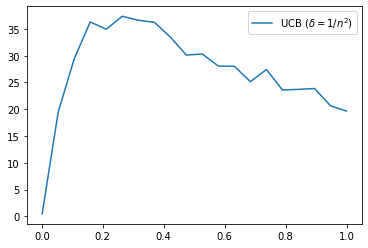

In [8]:
import matplotlib.pyplot as plt

plt.plot(gaps, regrets_vanilla, label="UCB ($\delta=1/n^2$)")
plt.legend()

# UCB Algorithm: Asymptotic Optimality

See Chapter 8 in [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

In the introduced UCB algorithm, the confidence level depended on the horizon.
The bound of the following algorithm has the same order but has the smaller leading constant which governs the asymptotic rate of growth of regret.

In [9]:
config = UcbSolver.DefaultConfig(ucb_type="asymptotic_optimal")
mixins = UcbSolver.make_mixins(env, config)
solver = UcbSolver.factory(env, config, mixins)

def calc_regret(gap, n_eval=50):
    env.rew_mean = np.array([0.0, -gap])
    config = UcbSolver.DefaultConfig(
        ucb_type="asymptotic_optimal",
        verbose=False, 
        steps_per_epoch=n_step, 
        add_interval=1, 
    )
    
    regret = 0
    for seed in range(n_eval):
        config.seed = seed
        solver.initialize(env, config)
        solver.run()
        regret += solver.scalars["Regret"]["y"][-1]
    return regret / n_eval

2022-01-04T23:49:12.575619Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 1000, 'verbose': True, 'ucb_type': <UCB_TYPE.asymptotic_optimal: 2>} env_id=None solver_id=MixedSolver-1
2022-01-04T23:49:12.577573Z set_env is called.             env_id=0 solver_id=MixedSolver-1
/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
2022-01-04T23:49:12.583171Z Solver is initialized.         env_id=0 methods=['BaseSolver.__init__', 'UcbSolver.act', 'History.add_scalar', 'AsymptoticOptimalUcbMixIn.calc_ucb', 'BanditEvalMixIn.evaluate', 'History.init_history', 'BanditEvalMixIn.initialize', 'History.load', 'UcbSolver.make_mixins', 'History.recent_summary', 'BaseSolver.run', 'History.save', 'BaseSolver.seed', 'History.set_config', '

In [10]:
solver.mixins

[shinrl.solvers.bandit.ucb_solver.AsymptoticOptimalUcbMixIn,
 shinrl.solvers.bandit.base_mixin.BanditEvalMixIn,
 shinrl.solvers.bandit.ucb_solver.UcbSolver]

In [11]:
gaps = np.linspace(0.001, 1.0, 20)
regrets_asymptotic = []

for gap in gaps:
    print(f"Evaluating regrets of: gap=={gap}")
    regrets_asymptotic.append(calc_regret(gap))

Evaluating regrets of: gap==0.001


/home/rl-dqn/ShinRL-JAX/shinrl/solvers/bandit/ucb_solver.py:99: RuntimeWarning: invalid value encountered in true_divide
  n_acts == 0, np.infty, rew_avg + np.sqrt(2 * np.log(f_t) / n_acts)
/home/rl-dqn/ShinRL-JAX/shinrl/solvers/bandit/ucb_solver.py:99: RuntimeWarning: divide by zero encountered in true_divide
  n_acts == 0, np.infty, rew_avg + np.sqrt(2 * np.log(f_t) / n_acts)


Evaluating regrets of: gap==0.05357894736842105
Evaluating regrets of: gap==0.1061578947368421
Evaluating regrets of: gap==0.15873684210526315
Evaluating regrets of: gap==0.2113157894736842
Evaluating regrets of: gap==0.26389473684210524
Evaluating regrets of: gap==0.3164736842105263
Evaluating regrets of: gap==0.36905263157894735
Evaluating regrets of: gap==0.4216315789473684
Evaluating regrets of: gap==0.47421052631578947
Evaluating regrets of: gap==0.5267894736842105
Evaluating regrets of: gap==0.5793684210526315
Evaluating regrets of: gap==0.6319473684210526
Evaluating regrets of: gap==0.6845263157894736
Evaluating regrets of: gap==0.7371052631578947
Evaluating regrets of: gap==0.7896842105263158
Evaluating regrets of: gap==0.8422631578947368
Evaluating regrets of: gap==0.8948421052631579
Evaluating regrets of: gap==0.9474210526315789
Evaluating regrets of: gap==1.0


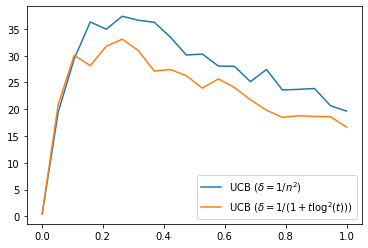

In [12]:
import matplotlib.pyplot as plt

plt.plot(gaps, regrets_vanilla, label="UCB ($\delta=1/n^2$)")
plt.plot(gaps, regrets_asymptotic, label="UCB ($\delta=1/(1 + t\log^2(t))$)")
plt.legend()

# UCB Algorithm: Minimax Optimality 

See Chapter 9 in [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

The previous two UCB have a worst-case regret of $R_{n}=O(\sqrt{k n \log (n)})$.
The following UCB variant, `minimax optimal strategy in the stochastic case (MOSS)`, entirely removes the log factor and has a worst-case regret of $R_{n}=O(\sqrt{k n})$.

In [13]:
config = UcbSolver.DefaultConfig(ucb_type="moss")
mixins = UcbSolver.make_mixins(env, config)
solver = UcbSolver.factory(env, config, mixins)

def calc_regret(gap, n_eval=50):
    env.rew_mean = np.array([0.0, -gap])
    config = UcbSolver.DefaultConfig(
        ucb_type="moss",
        verbose=False, 
        steps_per_epoch=n_step, 
        add_interval=1, 
    )
    
    regret = 0
    for seed in range(n_eval):
        config.seed = seed
        solver.initialize(env, config)
        solver.run()
        regret += solver.scalars["Regret"]["y"][-1]
    return regret / n_eval

2022-01-04T23:55:59.134456Z set_config is called.          config={'seed': 0, 'discount': 0.99, 'eval_trials': 10, 'eval_interval': 100, 'add_interval': 100, 'steps_per_epoch': 1000, 'verbose': True, 'ucb_type': <UCB_TYPE.moss: 3>} env_id=None solver_id=MixedSolver-2
2022-01-04T23:55:59.135856Z set_env is called.             env_id=0 solver_id=MixedSolver-2
/home/rl-dqn/miniconda3/envs/shinrl-jax/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
2022-01-04T23:55:59.140096Z Solver is initialized.         env_id=0 methods=['BaseSolver.__init__', 'UcbSolver.act', 'History.add_scalar', 'MossUcbMixIn.calc_ucb', 'BanditEvalMixIn.evaluate', 'History.init_history', 'BanditEvalMixIn.initialize', 'History.load', 'UcbSolver.make_mixins', 'History.recent_summary', 'BaseSolver.run', 'History.save', 'BaseSolver.seed', 'History.set_config', 'BaseSolver.set_env', 'UcbSo

In [14]:
solver.mixins

[shinrl.solvers.bandit.ucb_solver.MossUcbMixIn,
 shinrl.solvers.bandit.base_mixin.BanditEvalMixIn,
 shinrl.solvers.bandit.ucb_solver.UcbSolver]

In [15]:
gaps = np.linspace(0.001, 1.0, 20)
regrets_moss = []

for gap in gaps:
    print(f"Evaluating regrets of: gap=={gap}")
    regrets_moss.append(calc_regret(gap))

Evaluating regrets of: gap==0.001


/home/rl-dqn/ShinRL-JAX/shinrl/solvers/bandit/ucb_solver.py:114: RuntimeWarning: divide by zero encountered in true_divide
  log_plus = np.log(np.maximum(1, n / (k * n_acts)))


Evaluating regrets of: gap==0.05357894736842105
Evaluating regrets of: gap==0.1061578947368421
Evaluating regrets of: gap==0.15873684210526315
Evaluating regrets of: gap==0.2113157894736842
Evaluating regrets of: gap==0.26389473684210524
Evaluating regrets of: gap==0.3164736842105263
Evaluating regrets of: gap==0.36905263157894735
Evaluating regrets of: gap==0.4216315789473684
Evaluating regrets of: gap==0.47421052631578947
Evaluating regrets of: gap==0.5267894736842105
Evaluating regrets of: gap==0.5793684210526315
Evaluating regrets of: gap==0.6319473684210526
Evaluating regrets of: gap==0.6845263157894736
Evaluating regrets of: gap==0.7371052631578947
Evaluating regrets of: gap==0.7896842105263158
Evaluating regrets of: gap==0.8422631578947368
Evaluating regrets of: gap==0.8948421052631579
Evaluating regrets of: gap==0.9474210526315789
Evaluating regrets of: gap==1.0


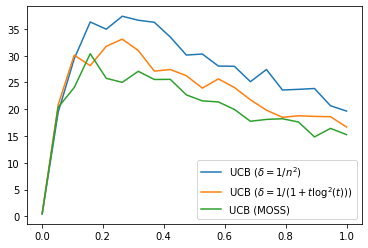

In [16]:
import matplotlib.pyplot as plt

plt.plot(gaps, regrets_vanilla, label="UCB ($\delta=1/n^2$)")
plt.plot(gaps, regrets_asymptotic, label="UCB ($\delta=1/(1 + t\log^2(t))$)")
plt.plot(gaps, regrets_moss, label="UCB (MOSS)")
plt.legend()